## <p style="font-family:Cambaria; font-weight:bold;  color:#006600; font-size:140%; text-align:left;padding: 0px;  border-bottom: 3px solid #003300;margin-bottom:-30px"> Table of Contents</p>

<ol>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#lib">Importing Libraries</a></li>
    <li><a href="#display">Visualizing images along with their captions</a></li>
    <li><a href="#xcep">Downloading Xception</a></li>
    <li><a href="#feature">Image Feature Extraction</a></li>
    <li><a href="#vector">Vector Embeddings</a></li>
    <li><a href="#datagen">Data Generation</a></li>
    <li><a href="#model">Model Architecture</a></li>
    <li><a href="#train">Training the Model</a></li>
    <li><a href="#bleu">Bleu Score on Test-set</a></li>
    <li><a href="#results">Results</a></li>
    <li><a href="#int">Testing on Random Images from Internet</a></li>
</ol>

## <p id ="intro" style="font-family:Cambaria; font-weight:bold;  color:#006600; font-size:140%; text-align:left;padding: 0px;  border-bottom: 3px solid #003300;margin-bottom:-30px"> Introduction</p>




<div style="border-radius:10px; border: 5px #003300 solid; padding: 15px; background-color: lightgreen; font-size:100%; text-align:left">
<h3 style="font-family:Cambaria; color:olive; text-align:center;"><b>Image Captioning</b></h3>
    <p style="font-family:Cambaria; font-size:18px; color:black; text-align: justify;">Image captioning aims to generate concise and relevant descriptions of the content depicted in an image, providing a summary rather than a detailed account. It extracts the most salient features from images and conveys them in natural language, acting as a bridge between Computer Vision and Natural Language Processing. Typically an encoder-decoder architecture is used for this type of task, where an input image is encoded into image features, which are then decoded into a descriptive text sequence. In this notebook I have used Xception to extract image features and LSTM as decoder.</p>


</div>

## <p id = "lib" style="font-family:Cambaria; font-weight:bold;  color:#006600; font-size:140%; text-align:left;padding: 0px;  border-bottom: 3px solid #003300; margin-bottom:-25px"> Importing Libraries</p>

In [1]:
import os
import time
import shutil
import pathlib
import itertools
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Concatenate, BatchNormalization, Bidirectional, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from textwrap import wrap
import warnings
import cv2
import matplotlib.patches as patches
import random
from tensorflow.keras.utils import Sequence
from IPython.display import Image
from gensim.models import Word2Vec
from nltk.translate.bleu_score import corpus_bleu
import gc
import requests
from io import BytesIO
# from PIL import Image




2024-06-27 11:44:22.704643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 11:44:22.704757: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 11:44:22.967272: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## <p id = "display" style="font-family:Cambaria; font-weight:bold;  color:#006600; font-size:140%; text-align:left;padding: 0px;  border-bottom: 3px solid #003300; margin-bottom:-25px"> Visualizing images along with their captions</p>

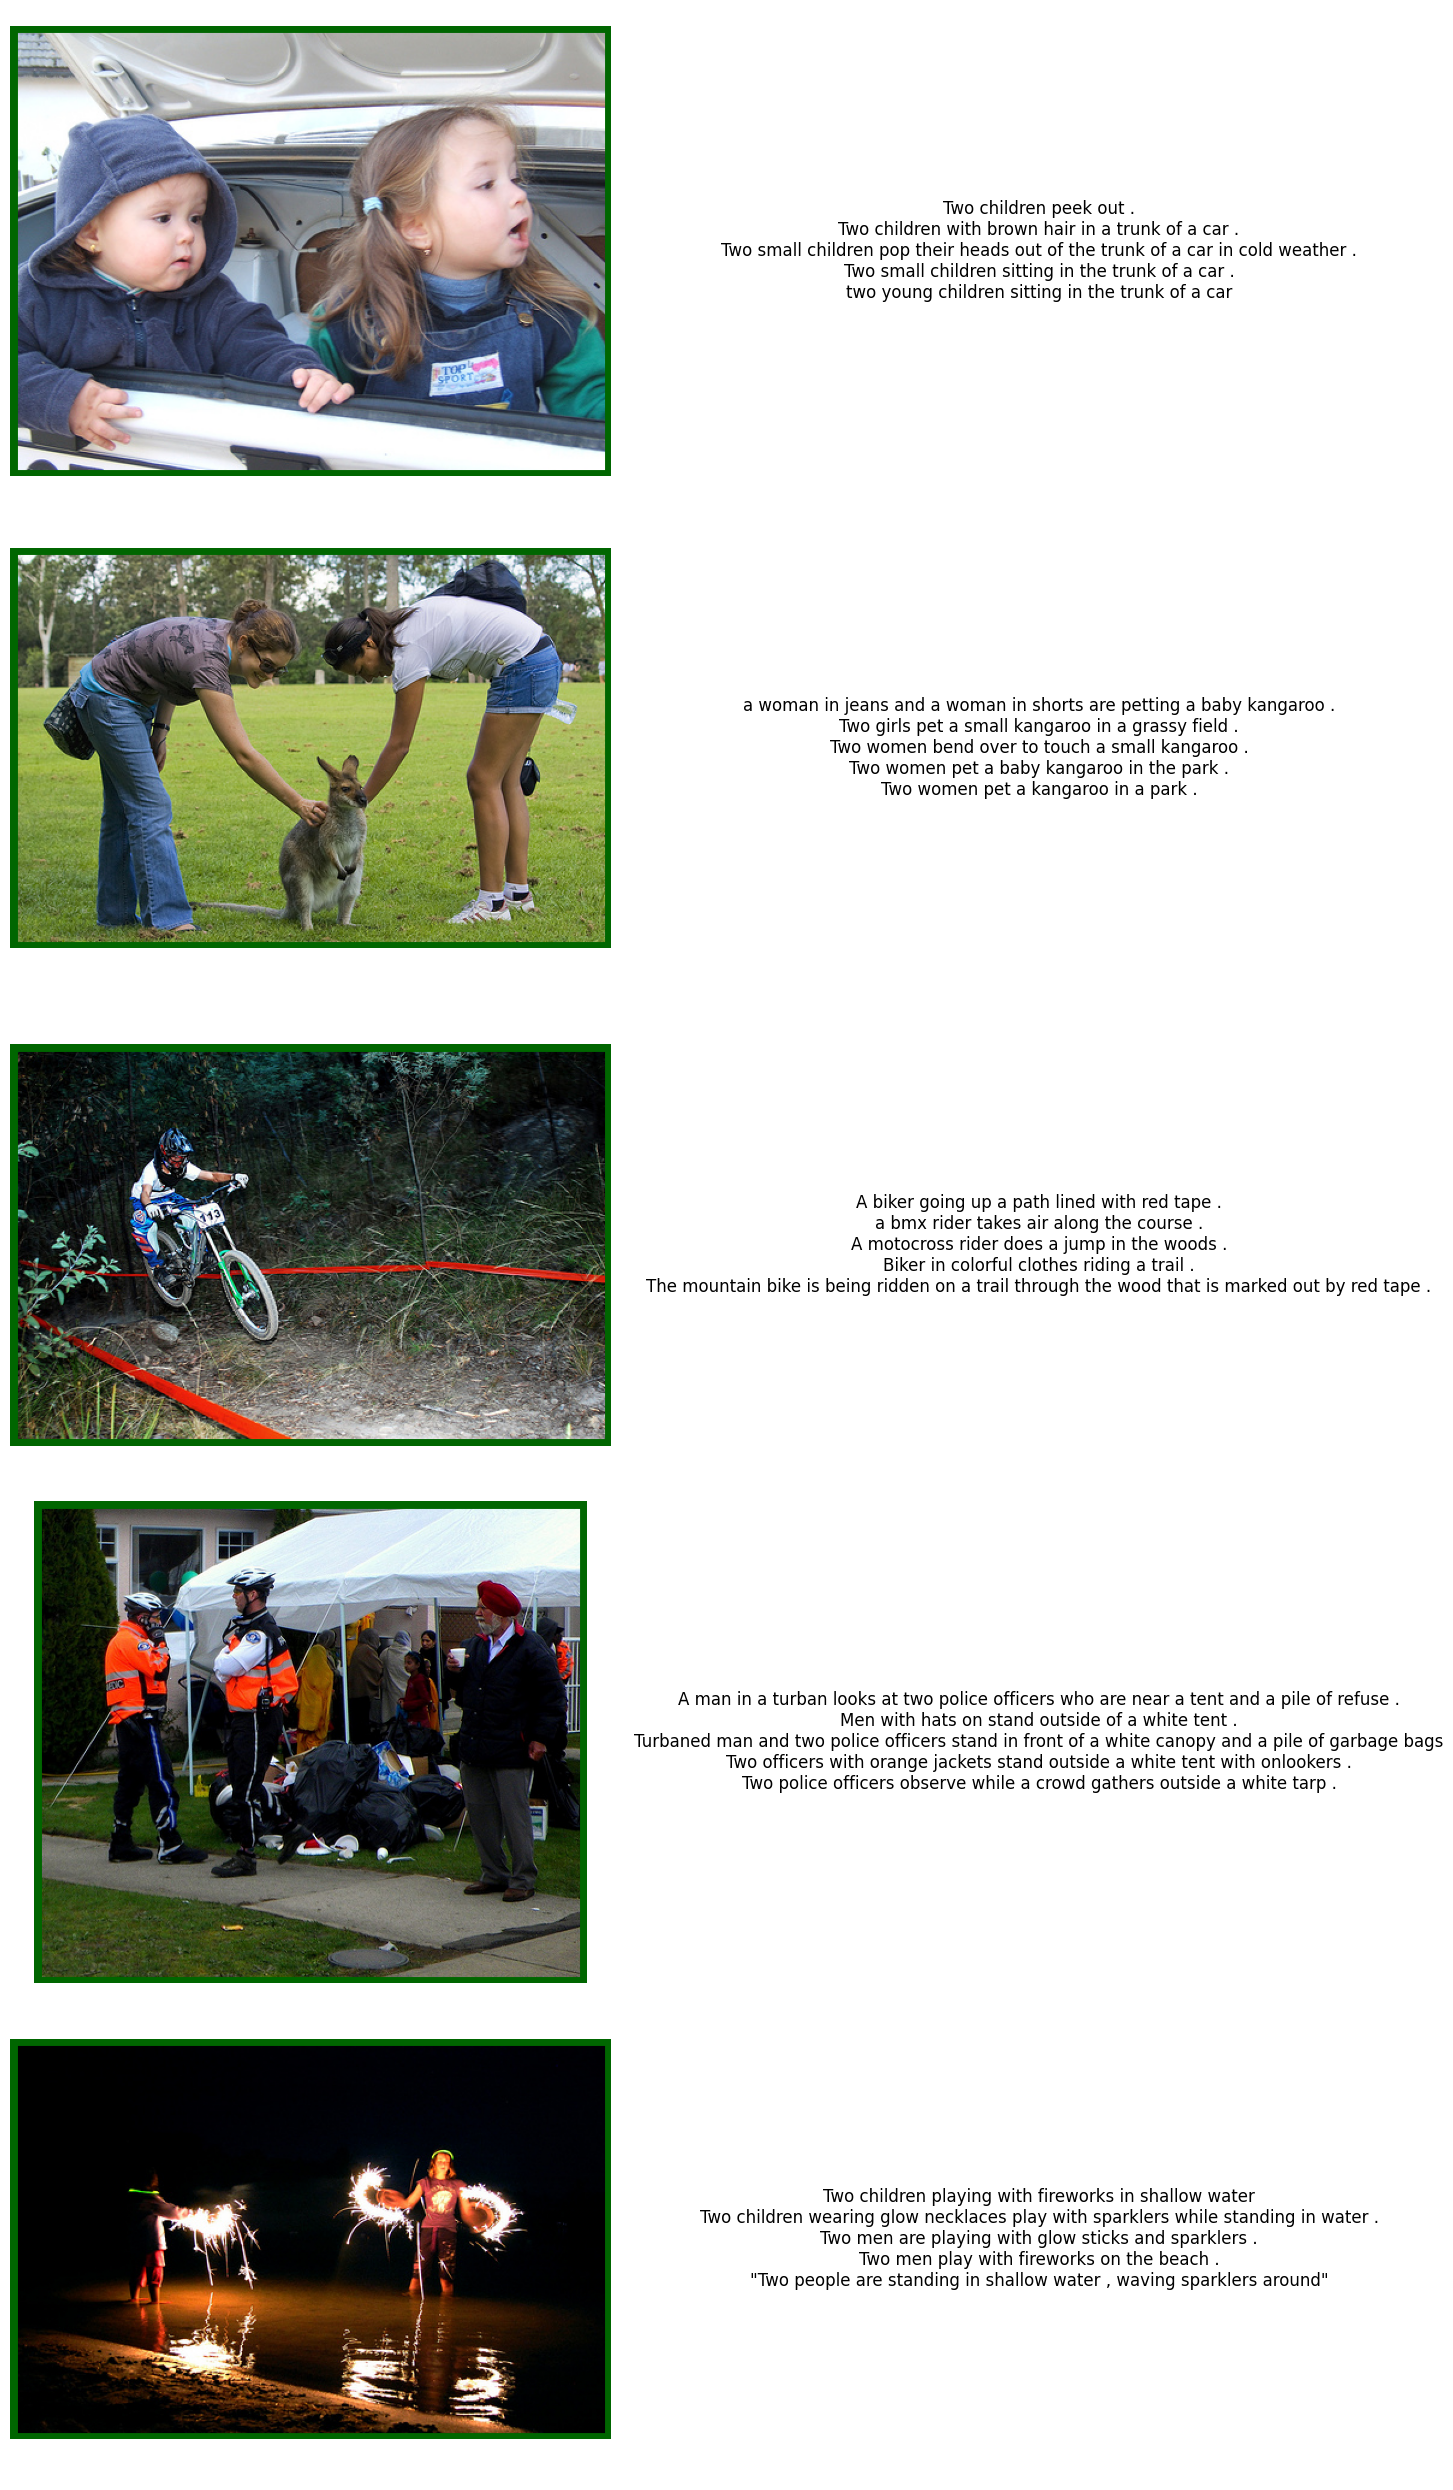

In [2]:


with open('/kaggle/input/flickr8k/captions.txt', 'r') as file:
    lines = file.readlines()

captions_dict = {}
for line in lines:
    image_name, caption = line.strip().split(',', 1)
    if image_name not in captions_dict:
        
        captions_dict[image_name] = []
    captions_dict[image_name].append(caption)

# 5 random images
selected_images = random.sample(list(captions_dict.keys()), 5)

fig, axes = plt.subplots(5, 2, figsize=(15, 25))

for idx, image_name in enumerate(selected_images):
   
    image_path = f'/kaggle/input/flickr8k/Images/{image_name}'
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    
    axes[idx, 0].imshow(image)
    axes[idx, 0].axis('off')
    
    
    
    rect = patches.Rectangle((0, 0), image.shape[1], image.shape[0], linewidth=10, edgecolor='#006600', facecolor='none')
    axes[idx, 0].add_patch(rect)
    
    
    captions = captions_dict[image_name]
    captions_text = "\n".join(captions)
    axes[idx, 1].text(0.5, 0.5, captions_text, ha='center', va='center', wrap=True, fontsize=12)
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

In [3]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working/'


data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")
data.head(10)

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   
5  1001773457_577c3a7d70.jpg   
6  1001773457_577c3a7d70.jpg   
7  1001773457_577c3a7d70.jpg   
8  1001773457_577c3a7d70.jpg   
9  1001773457_577c3a7d70.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
5         A black dog and a spotted dog are fighting  
6  A black dog and a tri-colored dog playing with...  
7  A black dog and a white dog with brown spots a...  
8  Two dogs of different breeds looking at each o...  
9    Two dogs on pavement moving toward each other .

## <p id="xcep" style="font-family:Cambaria; font-weight:bold;  color:#006600; font-size:140%; text-align:left;padding: 0px;  border-bottom: 3px solid #003300; margin-bottom:-25px"> Downloading Xception</p>

In [4]:
base_model = Xception(weights='imagenet', include_top=False) #with imagenet weights

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
x = base_model.output # since xception does not have any fully connected layers 
x = GlobalAveragePooling2D()(x) # added a avg pooling layer
model = Model(inputs=base_model.input, outputs=x)

In [6]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, None,      │        864 │ input_layer[0][0] │
│ (Conv2D)            │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, None,      │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, None,      │          0 │ block1_conv1_bn[… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, None,      │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, None,      │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, None,      │          0 │ block1_conv2_bn[… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, None,      │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, None,      │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, None,      │          0 │ block2_sepconv1_… │
│ (Activation)        │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, None,      │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, None,      │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │      8,192 │ block1_conv2_act… │
│                     │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, None,      │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 128)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None,      │          0 │ block2_pool[0][0… │
│                     │ None, 128)        │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, None,      │          0 │ add[0][0]       

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

## <p id="feature" style="font-family:Cambaria; font-weight:bold;  color:#006600; font-size:140%; text-align:left;padding: 0px;  border-bottom: 3px solid #003300; margin-bottom:-25px"> Image Feature Extraction</p>

In [7]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(299, 299))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1719488771.003201     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [9]:
#Load features
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [10]:
#Load Captions
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [11]:
# Create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [12]:
#function to clean the captions
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption
clean(mapping)

In [13]:
# Word2vector for vector embeddings of the text
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption.split())
word2vec_model = Word2Vec(all_captions, vector_size=512, window=5, min_count=1, workers=4)
vocab_size = len(word2vec_model.wv.index_to_key) + 1

In [14]:
# Create embedding matrix
embedding_dim = 512
embedding_matrix = np.zeros((vocab_size, embedding_dim))
word_index = {word: idx for idx, word in enumerate(word2vec_model.wv.index_to_key, 1)}
for word, idx in word_index.items():
    embedding_matrix[idx] = word2vec_model.wv[word]

In [15]:
max_length = max(len(caption) for caption in all_captions)
max_length

35

In [16]:
# Train-test split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [17]:
# Data generator function
def data_generator(data_keys, mapping, features, word_index, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = [word_index[word] for word in caption.split() if word in word_index]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                yield (np.array(X1), np.array(X2)), np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0

In [18]:
# Model architecture
inputs1 = Input(shape=(2048,))
fe1 = BatchNormalization()(inputs1)
fe2 = Dense(512, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True, weights=[embedding_matrix], trainable=False)(inputs2)
se2 = BatchNormalization()(se1)
se3 = Bidirectional(LSTM(256))(se2)

decoder = Concatenate()([fe2, se3])
decoder2 = Dense(512, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate=1e-4, clipvalue=5.0)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
# model.summary()

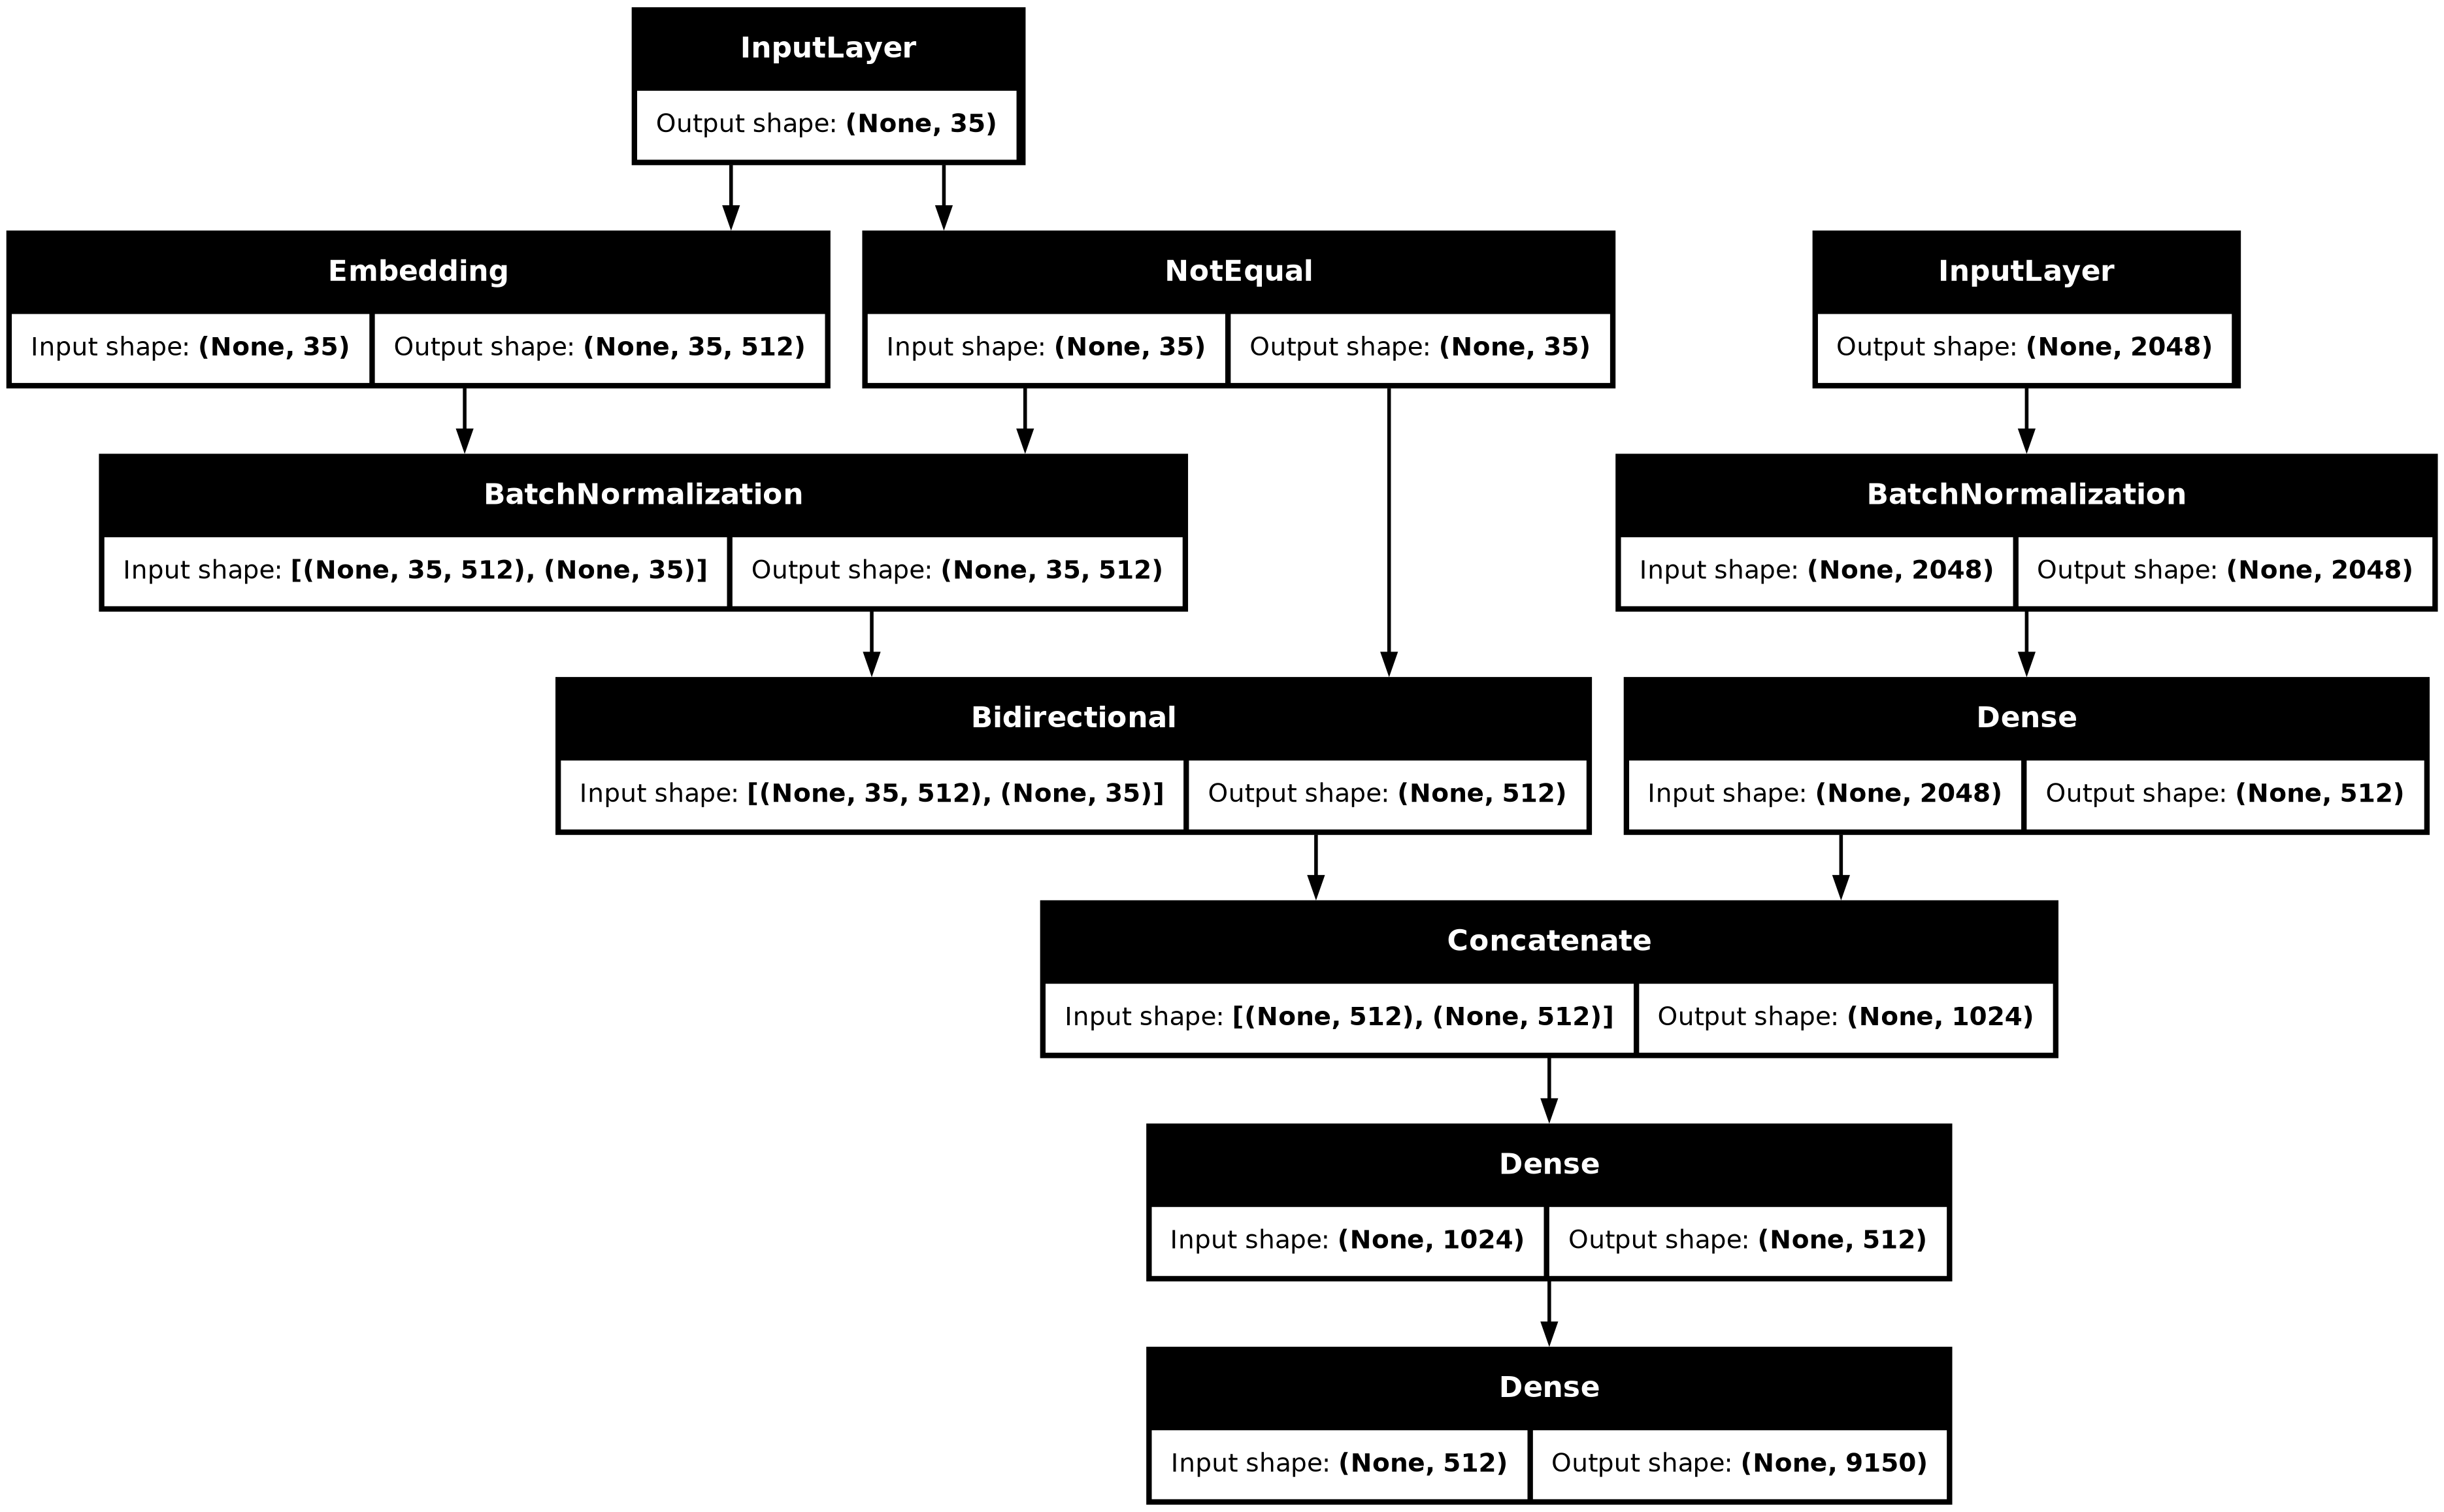

In [19]:
plot_model(model, show_shapes=True)

## <p id = "train" style="font-family:Cambaria; font-weight:bold;  color:#006600; font-size:140%; text-align:left;padding: 0px;  border-bottom: 3px solid #003300; margin-bottom:-25px"> Training the Model</p>

In [20]:
# Train the model
epochs = 40  #epochs > 64 causing memory error
batch_size = 32
steps = len(train) // batch_size
checkpoint_filepath = 'model_checkpoint.keras'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)

In [21]:
for i in range(epochs):
    generator = data_generator(train, mapping, features, word_index, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1, callbacks=[model_checkpoint_callback])


227/227 ━━━━━━━━━━━━━━━━━━━━ 65s 257ms/step - accuracy: 0.1164 - loss: 6.7626


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 256ms/step - accuracy: 0.2379 - loss: 4.5066
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 257ms/step - accuracy: 0.2780 - loss: 3.9772
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 258ms/step - accuracy: 0.2999 - loss: 3.6851
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 255ms/step - accuracy: 0.3169 - loss: 3.4758
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 257ms/step - accuracy: 0.3301 - loss: 3.3070
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 255ms/step - accuracy: 0.3415 - loss: 3.1619
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 256ms/step - accuracy: 0.3528 - loss: 3.0328
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 256ms/step - accuracy: 0.3637 - loss: 2.9159
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 255ms/step - accuracy: 0.3755 - loss: 2.8110
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 255ms/step - accuracy: 0.3882 - loss: 2.7187
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 256ms/step - accuracy: 0.4007 - loss: 2.6380
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 256ms/step - accuracy: 0.4120 - loss: 2.5664
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 257ms/step - accuracy: 0.4226 -

In [25]:
# Prediction functions
def idx_to_word(integer, word_index):
    for word, index in word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, word_index, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_index[word] for word in in_text.split() if word in word_index]
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, word_index)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [43]:
model.save(WORKING_DIR + '/model.keras')

In [34]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
    y_pred = predict_caption(model, features[image_id], word_index, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

## <p id = "results" style="font-family:Cambaria; font-weight:bold;  color:#006600; font-size:140%; text-align:left;padding: 0px;  border-bottom: 3px solid #003300; margin-bottom:-25px"> Results</p>

--------------------Predicted--------------------
startseq white dog with red collar shakes on the shore with ball in its mouth endseq


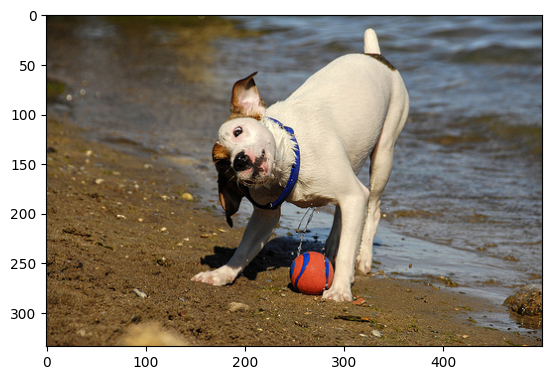

In [35]:
generate_caption('1012212859_01547e3f17.jpg')

--------------------Predicted--------------------
startseq man in blue jacket sitting in the snow with tent in the background endseq


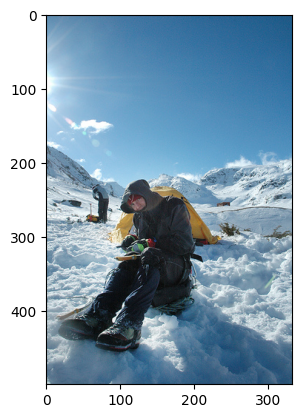

In [36]:
generate_caption('116409198_0fe0c94f3b.jpg')

--------------------Predicted--------------------
startseq white and brown dog is jumping in the air to catch yellow toy endseq


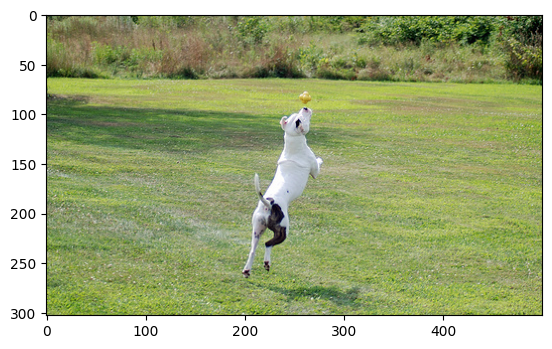

In [37]:
generate_caption("1020651753_06077ec457.jpg")


--------------------Predicted--------------------
startseq two young boys are playing with water and inflatable an inflatable seating endseq


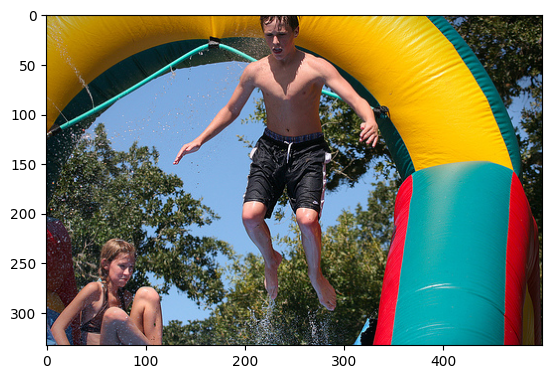

In [38]:
generate_caption("1087168168_70280d024a.jpg")

--------------------Predicted--------------------
startseq two people are ice ice in the ice endseq


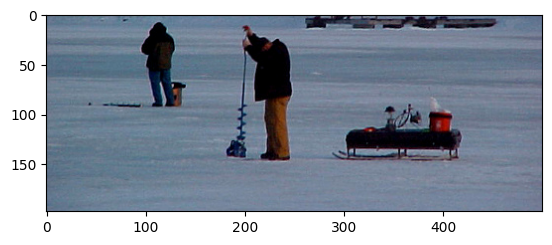

In [41]:
generate_caption("102351840_323e3de834.jpg")